In [1]:
import numpy as np
import GPy
import deepgp
from matplotlib import pyplot as plt

In [2]:
data = GPy.util.datasets.olympic_marathon_men()
x, y = data['X'], data['Y']

offset, scale = y.mean(), np.sqrt(y.var())

(2.5, 6.5)

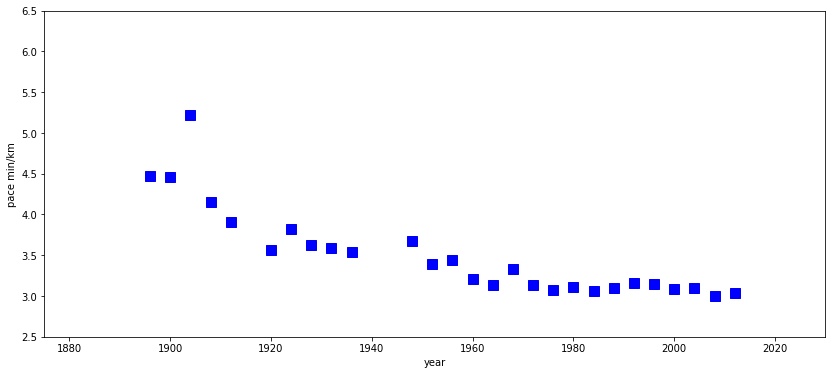

In [3]:
fig, ax = plt.subplots(figsize=(14,6))
_ = ax.plot(x, y, 'bs', ms = 10)
ax.set_xlabel('year')
ax.set_ylabel('pace min/km')

ax.set_xlim((1875, 2030))
ax.set_ylim((2.5, 6.5))

In [11]:
from GPy.mappings import Constant

In [12]:
m_full = GPy.models.GPRegression(x, y, mean_function=Constant(1,1), kernel=GPy.kern.RBF(1))
m_full.optimize()
display(m_full)

GP_regression.,value,constraints,priors
constmap.C,3.58824154210636,,
rbf.variance,0.27960601526408146,+ve,
rbf.lengthscale,20.79707416238572,+ve,
Gaussian_noise.variance,0.04190680752642991,+ve,


(2.5, 6.5)

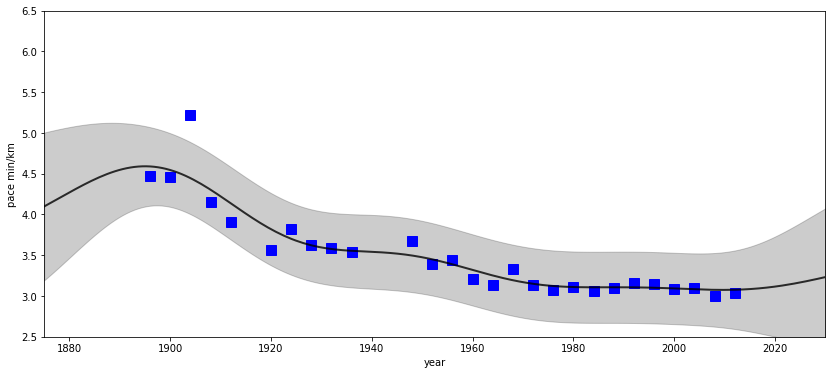

In [14]:
fig, ax = plt.subplots(figsize=(14,6))
_ = ax.plot(x, y, 'bs', ms = 10)

xnew = np.linspace(1875, 2030, 200)[:,None]

y_pred_mean, y_pred_var = m_full.predict(xnew, full_cov=False, include_likelihood=True)

y_pred_lci, y_pred_uci  = m_full.predict_quantiles(xnew, (2.5, 97.5), likelihood=m_full.likelihood)

_ = ax.plot(xnew, y_pred_mean, 'k-', alpha=0.8, lw=2)
_ = ax.fill_between(xnew.ravel(), y_pred_lci.ravel(), y_pred_uci.ravel(), color='k', alpha=0.2)

ax.set_xlabel('year')
ax.set_ylabel('pace min/km')

ax.set_xlim((1875, 2030))
ax.set_ylim((2.5, 6.5))



## Deep GP

In [16]:
num_hidden = 1
m = deepgp.DeepGP(
    [y.shape[1], num_hidden, x.shape[1]],
    Y = y,
    X = x,
    inits = ['PCA', 'PCA'],
    kernels = [GPy.kern.RBF(num_hidden, ARD=True), GPy.kern.RBF(x.shape[1], ARD=True)],
    num_inducing = 50,
    back_constraint = False
)

In [17]:
m.initialize_parameter()
display(m)

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(50, 1)",,
obslayer.rbf.variance,1.0,+ve,
obslayer.rbf.lengthscale,1.0,+ve,
obslayer.Gaussian_noise.variance,1.0,+ve,
obslayer.Kuu_var,"(50,)",+ve,
obslayer.latent space.mean,"(27, 1)",,
obslayer.latent space.variance,"(27, 1)",+ve,
layer_1.inducing inputs,"(50, 1)",,
layer_1.rbf.variance,1.0,+ve,
layer_1.rbf.lengthscale,1.0,+ve,


In [18]:
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
    layer.likelihood.variance = 1.
m.optimize(messages=True, max_iters=10000)

In [50]:
?m.predict

In [19]:
y_pred_mean, y_pred_cov = m.predict(xnew, full_cov=True)

y_pred_lci, y_pred_uci  = m.predict_quantiles(xnew, (2.5, 97.5))

(2.5, 6.5)

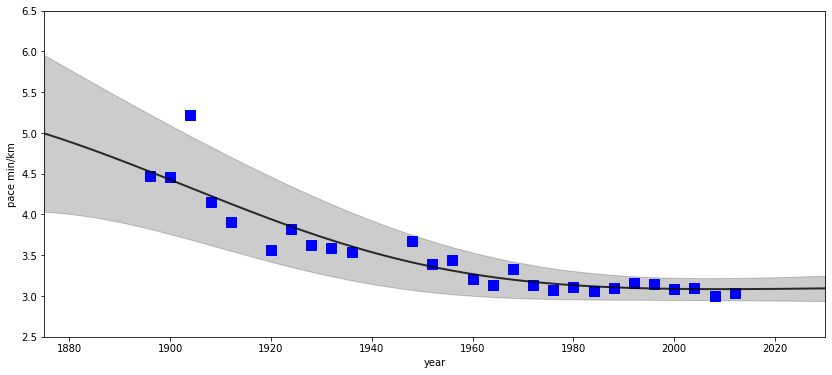

In [21]:
fig, ax = plt.subplots(figsize=(14,6))
_ = ax.plot(x, y, 'bs', ms = 10)

xnew = np.linspace(1875, 2030, 200)[:,None]

_ = ax.plot(xnew, y_pred_mean, 'k-', alpha=0.8, lw=2)
_ = ax.fill_between(xnew.ravel(), y_pred_lci.ravel(), y_pred_uci.ravel(), color='k', alpha=0.2)

ax.set_xlabel('year')
ax.set_ylabel('pace min/km')

ax.set_xlim((1875, 2030))
ax.set_ylim((2.5, 6.5))



In [23]:
def sample_dgp(model, xnew, num_samples=1, include_likelihood=False, output_hidden=False):
    samples = []
    for _ in range(num_samples):
        layer_input = xnew
        sample_hierarchy = []
        for i, layer in enumerate(reversed(model.layers)):
            l_mu, l_cov = layer.predict(layer_input, full_cov=True, include_likelihood=include_likelihood)
            layer_input = l_mu + np.linalg.cholesky(l_cov + 1e-8*np.eye(xnew.shape[0]))@np.random.randn(*xnew.shape)
            if output_hidden:
                sample_hierarchy.insert(0, layer_input) # prepend
        samples.append(sample_hierarchy if output_hidden else layer_input)
    return samples

In [24]:
samples = sample_dgp(m, xnew,10, include_likelihood=True, output_hidden=False)

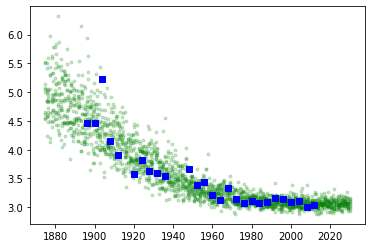

In [26]:
[plt.plot(xnew, sample, 'g.', alpha=0.2) for sample in samples]
plt.plot(x, y, 'bs')

In [27]:
display(m)

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(50, 1)",,
obslayer.rbf.variance,71.2275381082498,+ve,
obslayer.rbf.lengthscale,11.875983859439346,+ve,
obslayer.Gaussian_noise.variance,0.0032245087723830473,+ve,
obslayer.Kuu_var,"(50,)",+ve,
obslayer.latent space.mean,"(27, 1)",,
obslayer.latent space.variance,"(27, 1)",+ve,
layer_1.inducing inputs,"(50, 1)",,
layer_1.rbf.variance,8.313021399498249,+ve,
layer_1.rbf.lengthscale,99.30486964900896,+ve,


In [28]:
from scipy.signal import chirp

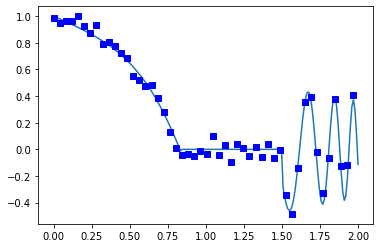

In [50]:
t = np.linspace(0., 2., 200)
f = np.exp(-t/2)*chirp(t, 0.1, 1., 1., method='logarithmic')*[0 if t_ >= .84 and t_ < 1.5 else 1 for t_ in t]

ts = t[::4]
y = f[::4] + 0.05*np.random.randn(50)
plt.plot(t, f)
plt.plot(ts, y, 'bs')
ts, y = ts[:,None], y[:,None]

In [51]:
m_full = GPy.models.GPRegression(ts, y, kernel=GPy.kern.RBF(1))
m_full.optimize(messages=True)

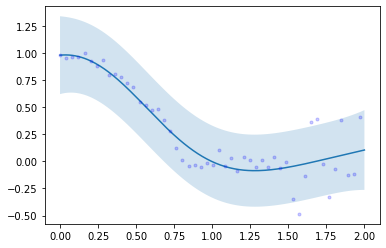

In [52]:
mu, var = m_full.predict(t[:,None], full_cov=False, include_likelihood=True)
plt.plot(t, mu)
plt.fill_between(t, (mu-1.96*np.sqrt(var)).ravel(), (mu+1.96*np.sqrt(var)).ravel(), alpha=0.2)
plt.plot(ts, y, 'b.', alpha=0.2)

In [55]:
m_1_layer = deepgp.DeepGP(
    [y.shape[1], 1, x.shape[1]],
    Y = y,
    X = ts,
    inits = ['PCA', 'PCA'],
    kernels = [GPy.kern.RBF(1, ARD=True), GPy.kern.RBF(x.shape[1], ARD=True)],
    num_inducing = 50,
    back_constraint = False
)
m_1_layer.initialize_parameter()

In [56]:
def optimise_dgp(model, messages=True):
    for layer in model.layers:
        layer.likelihood.variance.constrain_positive(warning=False)
        layer.likelihood.variance = 1.
    model.optimize(messages=True, max_iters=10000)

In [57]:
optimise_dgp(m_1_layer)

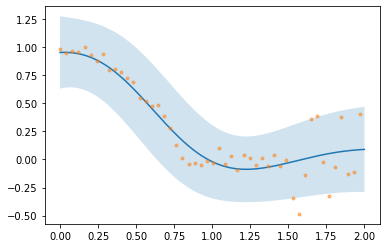

In [61]:
mu, _ = m_1_layer.predict(t[:,None])

lci, uci = m_1_layer.predict_quantiles(t[:,None], (2.5, 97.5))

plt.plot(t, mu, '-')
plt.fill_between(t.ravel(), lci.ravel(), uci.ravel(), alpha=0.2)
plt.plot(ts, y, '.', alpha=0.5)

In [63]:
def plot_dgp_layers(model, x):
    num_layers = len(model.layers)
    fig, axs = plt.subplots(num_layers, 1, figsize=(14, 5*num_layers))
    next_input = x
    for i, layer in enumerate(reversed(model.layers)):
        layer_out_mu, _ = layer.predict(next_input, include_likelihood=False)
        layer_out_lci, layer_out_uci = layer.predict_quantiles(next_input, (2.5, 97.5))
        axs[i].plot(next_input, layer_out_mu)
        axs[i].fill_between(next_input.ravel(), layer_out_lci.ravel(), layer_out_uci.ravel(), alpha=0.5)
        axs[i].set_title(layer.name)
        next_input = np.linspace(np.min(layer_out_lci), np.max(layer_out_uci), 200)[:,None]

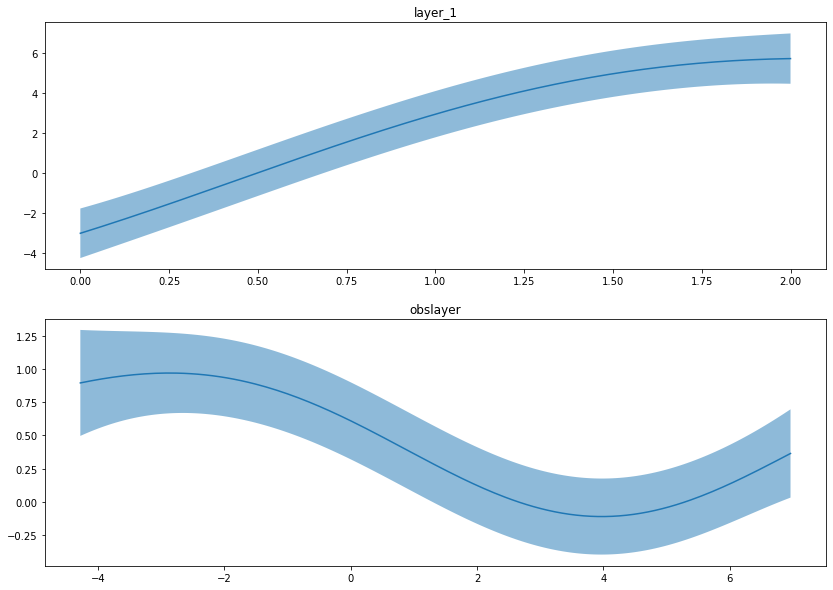

In [65]:
plot_dgp_layers(m_1_layer, t[:,None])

In [67]:
m_2_layer = deepgp.DeepGP(
    [y.shape[1], 1, 1, x.shape[1]],
    Y = y,
    X = ts,
    inits = ['PCA', 'PCA', 'PCA'],
    kernels = [GPy.kern.RBF(1), GPy.kern.RBF(1,ARD=False), GPy.kern.RBF(1,ARD=False), GPy.kern.RBF(x.shape[1], ARD=True)],
    num_inducing = 50,
    back_constraint = False
)
m_2_layer.initialize_parameter()

In [69]:
optimise_dgp(m_2_layer)

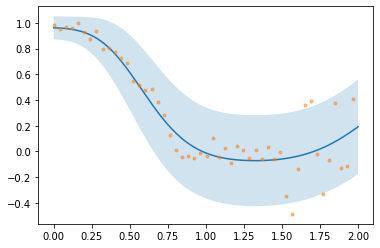

In [70]:
mu, _ = m_2_layer.predict(t[:,None])

lci, uci = m_2_layer.predict_quantiles(t[:,None], (2.5, 97.5))

plt.plot(t, mu, '-')
plt.fill_between(t.ravel(), lci.ravel(), uci.ravel(), alpha=0.2)
plt.plot(ts, y, '.', alpha=0.5)

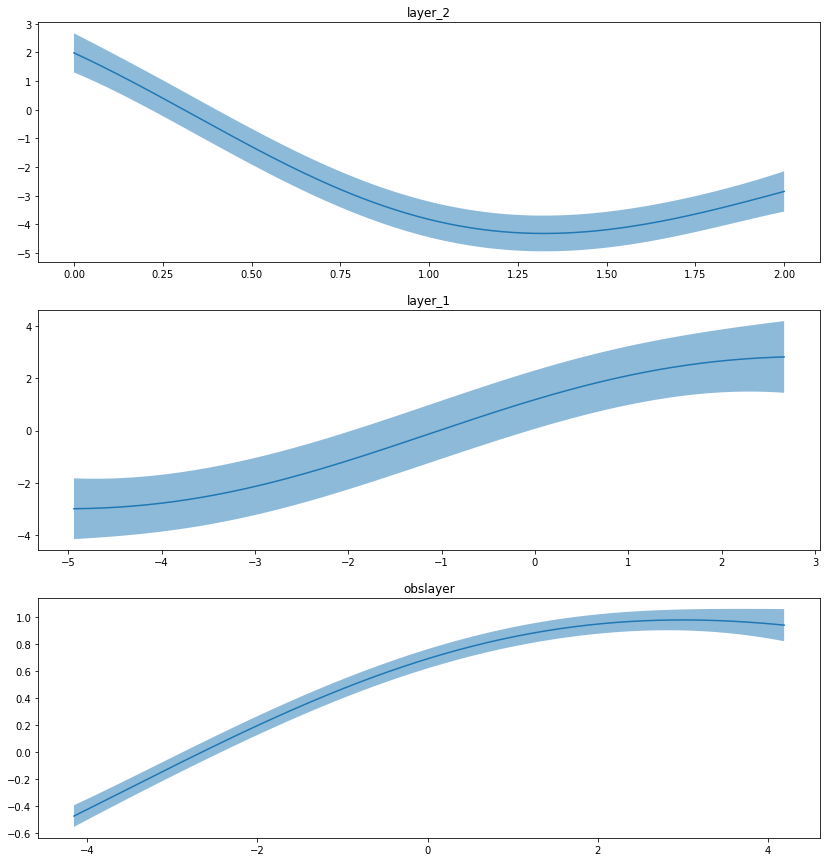

In [72]:
plot_dgp_layers(m_2_layer, t[:,None])

## 

In [226]:
from matplotlib import transforms, cm

def plot_dgp_warp(model, flip=False):
    x_ = model.layers[-1].X.values
    #x_ = np.linspace(np.min(X), np.max(X), 50)
    chain = x_.copy()
    for layer in reversed(model.layers):
        mu, _ = layer.predict(x_)
        chain = np.hstack([chain, mu])
        x_    = mu
    chain = chain[::(x_.shape[0]//50),:]
    ll, ul = np.min(chain[:,0]), np.max(chain[:,0])
    sc = ul - ll

    cmap = cm.get_cmap('viridis')

    newchain = chain.copy()
    for i in range(chain.shape[1]):
        lll, lul = np.min(newchain[:,i]), np.max(newchain[:,i])
        newchain[:,i] = ((newchain[:,i] - lll)/(lul-lll))*sc#ale

    #fig, ax = plt.subplots()
    ax = plt.gca()
    [ax.plot(newchain[i,:], np.arange(newchain.shape[1]), '-', c=cmap(i/50), lw=0.5, alpha=0.5) for i in range(newchain.shape[0])];

    ax2 = ax.twiny()
    ax2.set_xlim([*map(lambda a: (a/sc*(lul-lll) + lll),ax.get_xlim())])
    ax.set_yticks(np.arange(len(model.layers)+1)), ax.set_yticklabels(['input', *[layer.name for layer in reversed(model.layers)]]);
    
    ax.set_xlabel('t')
    ax2.set_xlabel('y')
    if flip:
        ax.invert_yaxis()
        ax.xaxis.set_ticks_position('top'), ax.xaxis.set_label_position('top')
        ax2.xaxis.set_ticks_position('bottom'), ax2.xaxis.set_label_position('bottom')


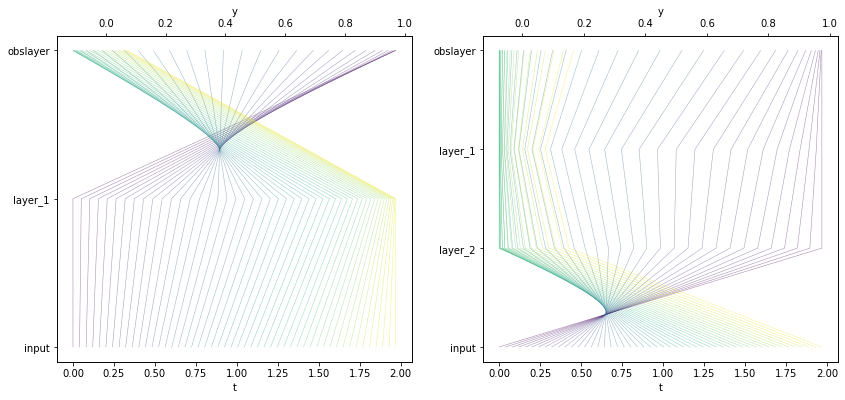

In [227]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plot_dgp_warp(m_1_layer, flip=False)
plt.subplot(122)
plot_dgp_warp(m_2_layer, flip=False)

In [102]:
layer_shape = [y.shape[1], 2, 2, 1, x.shape[1]]
kernels = [GPy.kern.RBF(i, ARD=True) for i in layer_shape[1:]]

m_3_layer = deepgp.DeepGP(
    layer_shape,
    Y = y,
    X = ts,
    inits = ['PCA']*len(kernels),
    kernels = kernels,
    num_inducing = 20,
    back_constraint = False
)
m_3_layer.initialize_parameter()


In [103]:
optimise_dgp(m_3_layer)

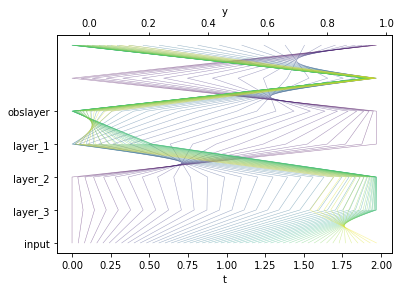

In [228]:
plot_dgp_warp(m_3_layer)

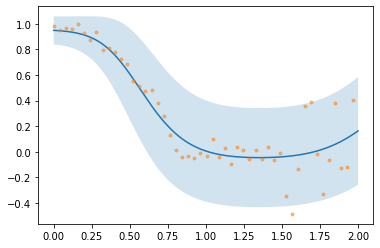

In [105]:
mu, _ = m_3_layer.predict(t[:,None])

lci, uci = m_3_layer.predict_quantiles(t[:,None], (2.5, 97.5))

plt.plot(t, mu, '-')
plt.fill_between(t.ravel(), lci.ravel(), uci.ravel(), alpha=0.2)
plt.plot(ts, y, '.', alpha=0.5)

In [114]:
samples = sample_dgp(m_3_layer, t[:,None], 100)

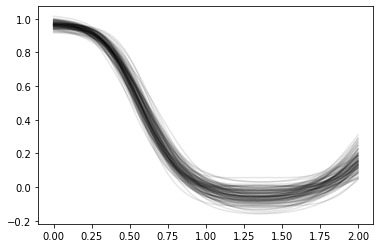

In [117]:
[plt.plot(t,sample, 'k-', alpha=0.1) for sample in samples];

### Step function

In [139]:
def alt_step(scale=1.):
    x = np.linspace(0., 1., 400)
    
    y = np.hstack([np.zeros(100), np.random.choice([0., 1.], size=(50,)), np.ones(100), np.random.choice([0., 1.], size=(50,)), np.zeros(100)])
    return x[:,None], y[:,None]

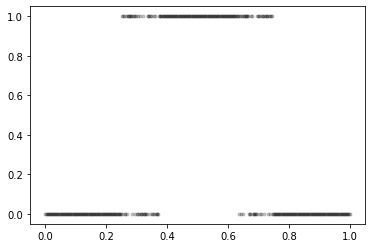

In [140]:
plt.plot(*alt_step(),'k.', alpha=0.2)
x, y = alt_step()

In [142]:
m_full = GPy.models.GPRegression(x, y, kernel=GPy.kern.RBF(1)+GPy.kern.Bias(1))
m_full.optimize()
display(m_full)

GP_regression.,value,constraints,priors
sum.rbf.variance,0.1952464941220559,+ve,
sum.rbf.lengthscale,0.16884210323982327,+ve,
sum.bias.variance,0.018331710605454566,+ve,
Gaussian_noise.variance,0.0694905936861625,+ve,


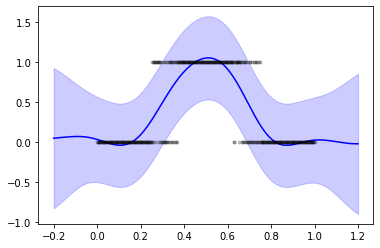

In [146]:
xnew = np.linspace(-0.2, 1.2, 500)[:,None]
lci, mu, uci = m_full.predict_quantiles(xnew, (2.5, 50, 97.5))

plt.plot(xnew, mu,'b-')
plt.fill_between(xnew.ravel(), lci.ravel(), uci.ravel(), color='blue', alpha=0.2)
plt.plot(x, y, 'k.', alpha=0.2)

In [176]:
m_deep = deepgp.DeepGP(
    [y.shape[1], 1, 1, x.shape[1]],
    X = x,
    Y = y,
    init = ['PCA','PCA','PCA'],
    kernels = [GPy.kern.RBF(1, ARD=True), GPy.kern.RBF(1, ARD=True), GPy.kern.RBF(x.shape[1], ARD=True)],
    num_inducing = 25,
    back_constraint=False
)
m_deep.initialize_parameter()

In [177]:
optimise_dgp(m_deep)

In [178]:
def plot_dgp_moments(model, x):
    mu, _ = model.predict(x)
    lci, uci = model.predict_quantiles(x, (2.5, 97.5))
    plt.plot(x, mu, '-')
    plt.fill_between(x.ravel(), lci.ravel(), uci.ravel(), alpha=0.2)

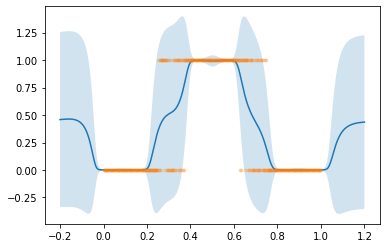

In [179]:
plot_dgp_moments(m_deep, xnew)
plt.plot(x, y, '.', alpha=0.2)

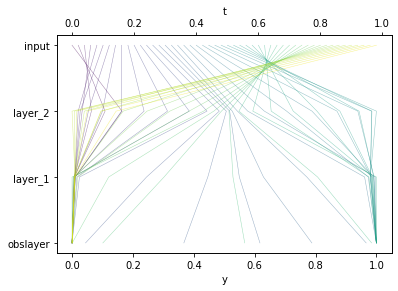

In [229]:
plot_dgp_warp(m_deep, flip=True)

In [184]:
latent_samples = sample_dgp(m_deep, xnew, 100)
obs_samples = sample_dgp(m_deep, xnew, 100, include_likelihood=True)

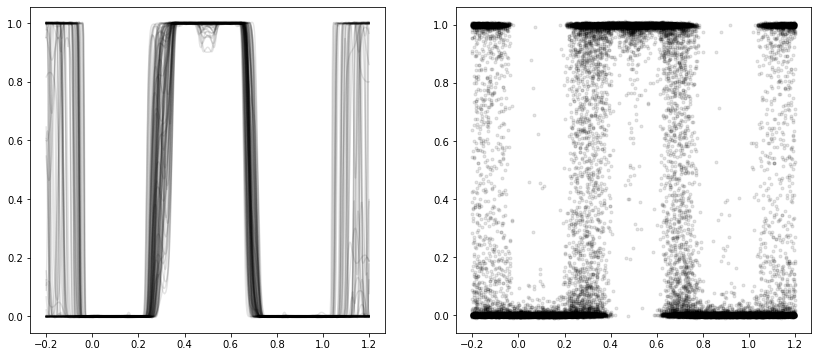

In [186]:
fig, axs = plt.subplots(1,2,figsize=(14,6))

[[ax.plot(xnew,sample, ls, alpha=0.1) for sample in samples] for ax,ls, samples in zip(axs,['k-','k.'],[latent_samples, obs_samples])];

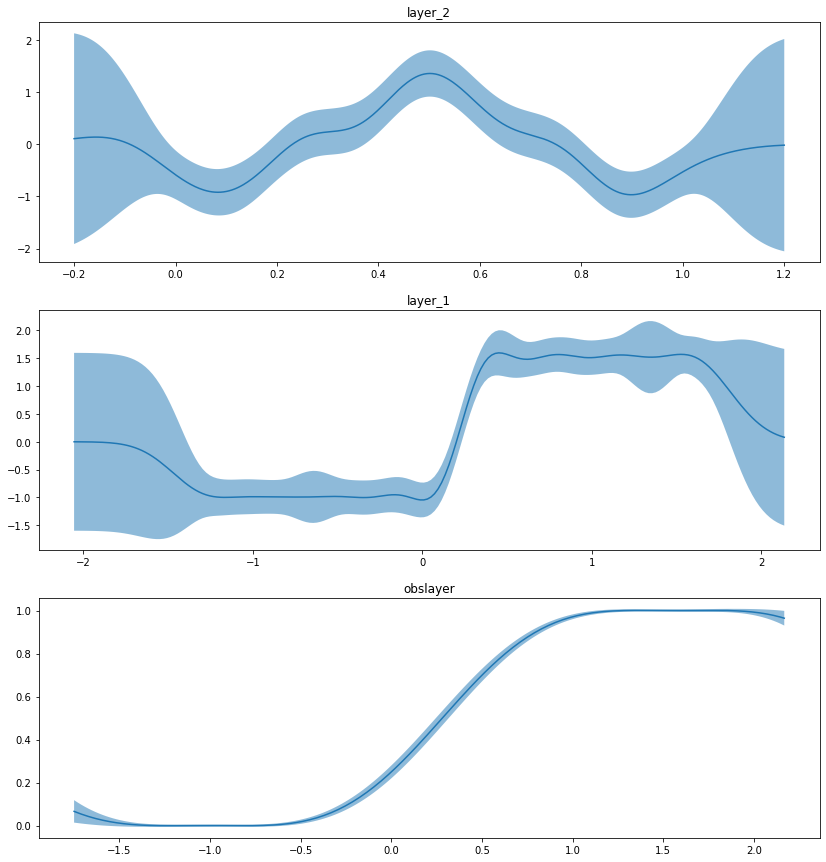

In [187]:
plot_dgp_layers(m_deep, xnew)